In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn import svm
import datetime as dt
from sklearn.ensemble import RandomForestClassifier 

In [2]:
df = pd.read_csv("./match_data_yearly/all_years.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(df["Date"])

In [3]:
df

,ID,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances,HomeElo,AwayElo,HomeED,AwayED
Date,,,,,,,,,,,,,,,,,
2006-03-04,6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916,1500,1500,0,0
2006-03-05,6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277,1500,1500,0,0
2006-03-05,6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531,1500,1500,0,0
2006-03-05,6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564,1500,1500,0,0
2006-03-05,6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199,1500,1500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251,1594,1560,4,-6
2020-12-19,20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825,1515,1524,9,-13
2020-12-19,20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966,1453,1458,17,7


In [4]:
accuracies = []
calibrations = []

for _ in range(10):
    for year in (2013,2014,2015,2016,2017,2018,2019,2020):

        df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
        X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_train = df_past["W/L"].values

        df_future = df[f"{year}"]
        X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_test = df_future["W/L"].values


        rf= RandomForestClassifier(max_depth=6)  
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        y_pred_proba=rf.predict_proba(X_test)

        accuracy = rf.score(X_test,y_test) 
        accuracies.append(accuracy)


        count=0

        pred_winrate_sum=0 # 予測勝率の和
        actual_win_sum=0 # 実勝利数の和

        pred_drawrate_sum=0 # 予測引き分け率の和
        actual_draw_sum=0 # 実引き分け数の和

        pred_lossrate_sum=0 # 予測敗率の和
        actual_loss_sum=0 # 実敗北数の和

        for index,row in df_future.iterrows():
            # ホームが実力上位
            if row["HomeElo"] > row["AwayElo"]: 
                pred_winrate_sum += y_pred_proba[count][1] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][2]

                if y_test[count] == 1: 
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            # アウェイが実力上位
            elif row["AwayElo"] > row["HomeElo"]: 
                pred_winrate_sum += y_pred_proba[count][2] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][1]

                if y_test[count] == 2:
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            count+= 1

        
        # 10ループ目の予測をpredict_probaをtoto予想に使用
#         df_y_pred_proba=pd.DataFrame(y_pred_proba)
#         df_y_pred_proba.insert(0,"MatchID",df_future["ID"].values)
#         df_y_pred_proba.to_csv(f"./predict_proba_data/{year}.csv", index=False)
        
        calibration = pred_winrate_sum/actual_win_sum
        calibrations.append(calibration)
#         print(f"{year} : {pred_winrate_sum/actual_win_sum :.2f} {pred_drawrate_sum/actual_draw_sum :.2f} {pred_lossrate_sum/actual_loss_sum :.2f}   {accuracy:.2f}")

        
# 8シーズン×10回の精度の平均
print("2013~2020の8シーズンを10回分予測")
print(f"的中率の平均値 : {np.mean(accuracies):.3f}  較正値の平均値 : {np.mean(calibrations):.3f}")

2013~2020の8シーズンを10回分予測
的中率の平均値 : 0.462  較正値の平均値 : 0.978


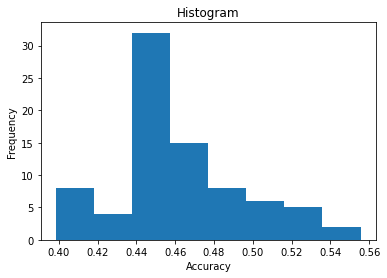

In [5]:
n, bins, patches=plt.hist(accuracies, bins=8)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

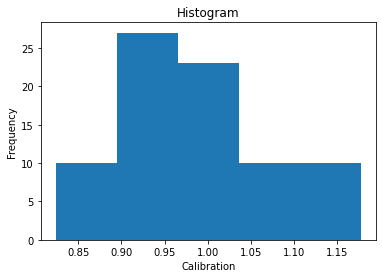

In [14]:
n, bins, patches=plt.hist(calibrations, bins=5)
plt.xlabel("Calibration")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [8]:
calibrations

[0.9085450008971806,
 0.9869123287693365,
 0.9395636225129472,
 0.9723121396084989,
 1.042115420183361,
 1.1774006658318847,
 0.9645708288731341,
 0.8323081414434264,
 0.9114873711071833,
 0.9841740525316691,
 0.9483612451275646,
 0.968720421049186,
 1.0482345912797209,
 1.1676283541601815,
 0.9748145352725666,
 0.8360759466552828,
 0.909436513057046,
 0.9857475430573305,
 0.9382184698967755,
 0.9814329026493673,
 1.0596475598339399,
 1.1641438455055597,
 0.9606608508719368,
 0.8362934921594465,
 0.9099644793448209,
 0.9839492338086968,
 0.9385068275743349,
 0.9781223332751261,
 1.040975179067357,
 1.1702888830764246,
 0.965446493800765,
 0.8317094018898677,
 0.9203308511858848,
 0.9887670875373792,
 0.940411733041919,
 0.9837424454139967,
 1.0373626630738213,
 1.1662372322905257,
 0.9644803740171501,
 0.8263932586425035,
 0.9137955160935896,
 0.9874639549367235,
 0.9307251332303064,
 0.9755557896643802,
 1.0484801891721345,
 1.1699620041623784,
 0.9683479985212926,
 0.8358963659274162

### 考察

以前まで外部サイトから取得していたeloratingとは違い今回は自分で算出したところ､精度が大きく下がった｡以前までの所得方法に誤りがあった可能性がある｡
また､今後の拡張性も考慮して自分で算出したratingを用いる｡

rating値しか使っていないので､ratingの大小で分類されやすく分類の精度が伸びていないのでは?と考えられる

較正値での検証では､ (予測勝率の和)/(実際の勝利数)が0を下回るため､予測モデルが過小評価している傾向にあることも分かる｡
ただ､引き分けをほとんど予測しないモデルだが､較正値で検証すると､引き分けを程よく判断できているとも取れる｡

In [5]:
accuracies = []
calibrations = []

# BEGIN

In [10]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

accuracy = rf.score(X_test,y_test) 
accuracies.append(accuracy)


count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 

    count+= 1

calibration = pred_winrate_sum/actual_winrate_sum
calibrations.append(calibration)

In [11]:
rf.feature_importances_

array([0.47969597, 0.52030403])

In [13]:
!conda install -c conda-forge mlxtend -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/yokoyama/anaconda3

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38h578d9bd_1         3.1 MB  conda-forge
    mlxtend-0.19.0             |     pyhd8ed1ab_0         1.2 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  mlxtend            conda-forge/noarch::mlxtend-0.19.0-pyhd8ed1ab_0
  python_abi         conda-forge/linux-64::python_abi-3

<AxesSubplot:>

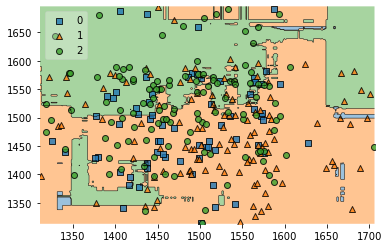

In [19]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X_test, y=y_test, clf=rf, legend=2)

<AxesSubplot:>

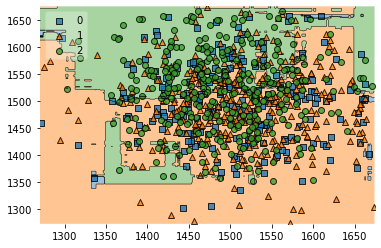

In [16]:
plot_decision_regions(X=X_train, y=y_train, clf=rf, legend=2)

In [17]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.5403050108932462, 0.43790849673202614)

In [18]:
pd.value_counts(y_train), pd.value_counts(y_test)

(1    382
 2    322
 0    214
 dtype: int64,
 2    120
 1    118
 0     68
 dtype: int64)

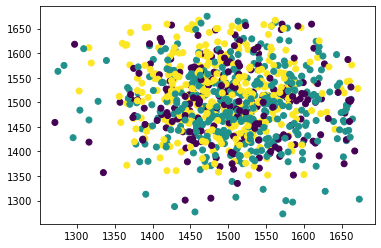

In [21]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# ---

In [22]:
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1234)
X_embedded = tsne.fit_transform(X_train)

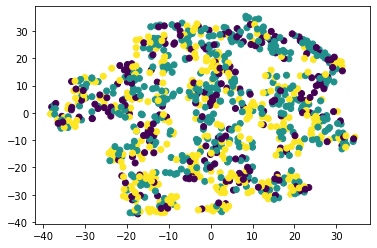

In [23]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)

# END

In [6]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

accuracy = rf.score(X_test,y_test) 
accuracies.append(accuracy)


count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 

    count+= 1

calibration = pred_winrate_sum/actual_winrate_sum
calibrations.append(calibration)

In [9]:
rf.feature_importances_

array([0.28149834, 0.32998085, 0.20341988, 0.18510093])

In [7]:
# 2010~2020の試合の"W/L"の各回数
df["W/L"].value_counts()

1    1936
2    1576
0    1078
Name: W/L, dtype: int64

In [8]:
# 予測したy_predの0,1,2の各出現回数
print("予測")
print(pd.Series(y_pred).value_counts())
print("======")
print("実際")
# 実際のy_testの0,1,2の各出現回数
print(pd.Series(y_test).value_counts())

予測
1    192
2    113
0      1
dtype: int64
実際
2    120
1    118
0     68
dtype: int64


1(ホーム勝利)に分類しまくってしまっている｡ 0(引き分け)を1と分類してしまっているともとれる??

0と1と2の大小関係的に､1が真ん中で分類されやすい可能性あり 
→ 0(ホーム勝利),1(引き分け),2(ホーム敗北)でやってみたが､効果なし｡

単純に過去の試合からホームのほうが勝率が高い傾向にあるので､それが影響しているだけかな?

In [76]:
# y_pred_proba=rf.predict_proba(X_test)
# y_pred_proba # [引き分け, ホーム勝ち, アウェイ勝ち]

In [77]:
y_pred

array([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2,
       2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,

In [78]:
count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 
    
    count+= 1

In [79]:
pred_winrate_sum

134.0777071782087

In [80]:
actual_winrate_sum

161

In [81]:
# 較正値(予測勝率と実勝率との比)
pred_winrate_sum/actual_winrate_sum 

0.8327807899267621

### 考察

較正値で評価すると､概ね1±0.2あたりに収まることから､eloratingで勝率を予測できることが分かる｡
改善の余地もまだまだある

In [82]:
match_id_list = df_future["ID"].values
match_result_list = df_future["W/L"].values

## toto予想

ホームクラブの勝率のみを考慮して､toto予想(0,1,2のどれを買うか)をしてみた｡

In [83]:
count = 0

print("結果 予想 正誤")

for (mid, ypred, result) in zip(match_id_list, y_pred_proba, match_result_list):
    if ypred[1] > 0.6 :
        if result == 1:
            print(f"{result} 1       ○")
            count += 1
        else:
            print(f"{result} 1       ✕")
    elif ypred[1] > 0.5:
        if result == 1 or result == 0:
            print(f"{result} 10    ○")
            count += 1
        else:
            print(f"{result} 10    ✕")
    elif ypred[1] > 0.4:
        print(f"{result} 102 ○") 
        count += 1
    elif ypred[1] > 0.3:
        if result == 0 or result == 2 :
            print(f"{result} 02    ○")
            count += 1
        else:
            print(f"{result} 02    ✕")
    else:
        if result == 2:
            print(f"{result} 2       ○") 
            count += 1
        else:
            print(f"{result} 2       ✕")
            
print(f"的中率 : {count / len(match_id_list)}")

結果 予想 正誤
2 02    ○
0 102 ○
1 102 ○
1 102 ○
0 102 ○
2 02    ○
1 2       ✕
2 102 ○
0 10    ○
2 02    ○
2 02    ○
2 02    ○
1 02    ✕
2 02    ○
1 102 ○
2 02    ○
0 2       ✕
2 02    ○
1 10    ○
2 102 ○
2 10    ✕
2 102 ○
2 10    ✕
2 102 ○
1 102 ○
0 02    ○
2 02    ○
1 1       ○
0 102 ○
2 02    ○
0 102 ○
0 02    ○
0 02    ○
2 10    ✕
1 02    ✕
2 102 ○
1 02    ✕
2 2       ○
1 102 ○
0 102 ○
1 10    ○
2 02    ○
1 102 ○
1 102 ○
1 102 ○
1 10    ○
1 2       ✕
1 02    ✕
0 102 ○
0 02    ○
0 10    ○
2 02    ○
2 10    ✕
2 2       ○
1 02    ✕
2 102 ○
1 102 ○
0 02    ○
1 102 ○
1 1       ○
0 02    ○
2 102 ○
2 10    ✕
2 02    ○
2 2       ○
2 10    ✕
2 02    ○
2 02    ○
2 02    ○
0 10    ○
2 10    ✕
1 102 ○
1 102 ○
1 102 ○
1 1       ○
0 102 ○
1 10    ○
2 10    ✕
1 102 ○
0 02    ○
2 02    ○
1 102 ○
0 102 ○
1 2       ✕
1 102 ○
1 02    ✕
2 1       ✕
0 10    ○
2 02    ○
2 102 ○
0 02    ○
2 10    ✕
1 02    ✕
1 2       ✕
2 102 ○
0 102 ○
2 02    ○
1 02    ✕
2 10    ✕
1 102 ○
1 102 ○
0 02    ○
0 02    ○
1 102 ○
0

### toto予想 考察

ホームクラブの予想勝率だけで､賭け方を決めて､実際に予想してみたら､意外と○が多い｡
もっとリターン額を考えトリプルやダブルを減らした賭け方ができれば､現実世界でも使えそう｡

In [92]:
pd.DataFrame(y_pred_proba)[1]

0      0.377809
1      0.422145
2      0.454348
3      0.425647
4      0.478587
         ...   
301    0.502589
302    0.405848
303    0.438949
304    0.540604
305    0.446631
Name: 1, Length: 306, dtype: float64

<AxesSubplot:>

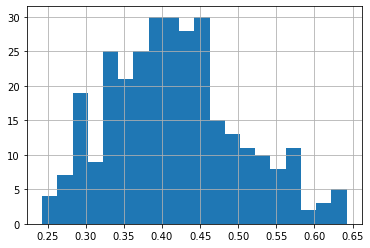

In [101]:
pd.DataFrame(y_pred_proba)[1].hist(bins=20)